# Klasyfikacja ręcznie pisanych cyfr z wykorzystaniem sieci konwolucyjnej i biblioteki Keras

In [1]:
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

### MNIST 

zbiór obrazków ręcznie pisanych cyfr, zadaniem jest rozpoznanie cyfry na obraku 

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


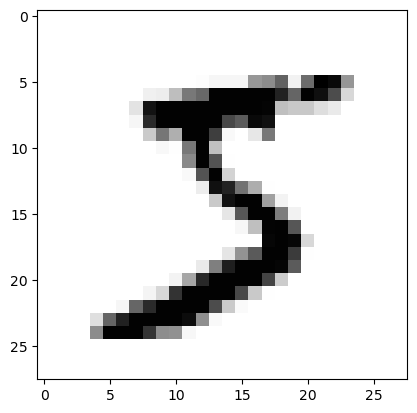

In [3]:
# wyświetlenie perwszego obrazka ze zbioru uczącego (o indeksie 0)
plt.set_cmap('Greys')
plt.imshow(x_train[0])
plt.show()

In [4]:
# etykieta dla pierwszego obrazka ze bioru uczącego
y_train[0]

5

In [5]:
# rozmiar pierwszego obrazka ze bioru uczącego
x_train[0].shape

(28, 28)

In [6]:
# kształt danych uczących - mamy 60000 obrazków o rozmiarze 28x28 pikseli
x_train.shape

(60000, 28, 28)

One hot encoding - mamy 10 możliwych wyjść: 0, 1, ..., 9. Kodujemy je w wektorze 0 i 1, tak, że w każdym wektorze jest tylko jedna jedynka, na odpowiednim miejscu. Przykładowo poniżej kodowanie "5" - 1 na 6. pozycji (bo zaczynamy od "0").

In [7]:
y_train_one_hot = keras.utils.to_categorical(y_train, 10)
y_test_one_hot = keras.utils.to_categorical(y_test, 10)

In [8]:
y_train_one_hot[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [9]:
# 1. Dane wejściowe do sieci konwolucyjnej powinny mieć rozmiar
# liczba przykładów x wysokość x szerokość x liczba kanałów
# przetwarzamy obrazy w skali szarości (1 kanał), ale liczba wymiarów powinna się zgadzać
# więc zamieniamy kształt 60000 x 28 x 28 na 60000 x 28 x 28 x 1
# 2. Piksele mają wartości od 0 do 255, więc dzieląc przez 255 normalizujemy dane wejściowe do zakresu <0, 1>
X_train = x_train.reshape(x_train.shape[0], 28, 28, 1)/255
X_test = x_test.reshape(x_test.shape[0], 28, 28, 1)/255

## CNN

Odtwarzamy (prawie) architekturę sieci LeNet z artykułu:

Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, november 1998


- sieć konwolucyjna - podajemy na wejście obrazek dwuwymiarowy, bez rozpłaszczania
- Conv2D - warstwa konwolucyjna, kernel_size - rozmiar filtra
- Flatten - "rozpłaszczenie" wyjścia warstw konwolucyjnych do jednego wymiaru, żeby można było zastosować warstwę Dense (każdy neuron warstwy poprzedniej połączony ze wszystkimi neuronami warstwy kolejnej)

In [11]:
model = keras.models.Sequential() # tworzymy model
# warstwa konwolucyjna: 6 filtrów, rozmiar filtra 5x5, funkcja aktywacji tangens hiperboliczny, padding same - uzupełnianie ramką zer, tak
# aby po operacji splotu rozmiar obrazka pozostał taki sam
model.add(layers.Conv2D(6, kernel_size=(5, 5), activation='tanh', padding='same', input_shape=(28, 28, 1)))
# average pooling w oknie o wymiarze 2 x 2 i z przesunięciem 2 x 2
model.add(layers.AveragePooling2D((2, 2), strides=(2, 2))) 

# warstwa konwolucyjna o 16 filtrach, brak uzupełniania ramką zer
model.add(layers.Conv2D(16, kernel_size=(5, 5), activation='tanh', padding='valid'))
model.add(layers.AveragePooling2D((2, 2), strides=(2, 2)))

model.add(layers.Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

# warstwa wypłaszczająca
model.add(layers.Flatten())

# warstwy gęsto połączone (mpl)
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 120)              

Przyjrzyjmy się podsumowaniu modelu:
1. Pierwsza warstwa konwolucyjna ma 6 filtrów o rozmiarze 5 x 5, co daje 6 x 5 x 5 = 150 wag filtrów + 6 biasów (po jednym na filtr) = 156 parametrów
2. Kształt po pierwszej warstwie to 28 x 28 x 6 - liczba kanałów odpowiada liczbie filtrów w poprzedającej warstwie konwolucyjnej
3. Po warstwie poolingu z oknem 2x2 i przesunięciem 2x2 wysokość i szerokość obrazka zmniejsza się dwukrotnie
4. Druga warstwa konwolucyjna ma 16 filtrów o wymiarze 5x5. Na wejściu tej warstwy mamy obrazek o 6 kanałach, więc każdy filtr ma tak naprawdę wymiar 5x5x6. Zatem dostajemy 16x5x5x6 + 16 (1 bias na filtr) = 2416 parametrów

In [13]:
# uczenie modelu
model.fit(x = X_train, y = y_train_one_hot, epochs = 20, batch_size = 1000)

Epoch 1/20


60/60 [==============================] - 7s 84ms/step - loss: 0.8373 - accuracy: 0.7974
Epoch 2/20
60/60 [==============================] - 5s 79ms/step - loss: 0.3001 - accuracy: 0.9098
Epoch 3/20
60/60 [==============================] - 5s 81ms/step - loss: 0.2228 - accuracy: 0.9321
Epoch 4/20
60/60 [==============================] - 5s 78ms/step - loss: 0.1722 - accuracy: 0.9485
Epoch 5/20
60/60 [==============================] - 5s 78ms/step - loss: 0.1369 - accuracy: 0.9589
Epoch 6/20
60/60 [==============================] - 5s 85ms/step - loss: 0.1139 - accuracy: 0.9658
Epoch 7/20
60/60 [==============================] - 6s 109ms/step - loss: 0.0958 - accuracy: 0.9720
Epoch 8/20
60/60 [==============================] - 7s 122ms/step - loss: 0.0812 - accuracy: 0.9762
Epoch 9/20
60/60 [==============================] - 7s 113ms/step - loss: 0.0704 - accuracy: 0.9793
Epoch 10/20
60/60 [==============================] - 6s 107ms/step - loss: 0.0618 - accuracy: 0.9821
Epo

In [37]:
# wyniki dla danych uczących
preds =  model.evaluate(x = X_train, y = y_train_one_hot)
print()
print(preds)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9936 - loss: 0.0242

[0.02474108710885048, 0.9932000041007996]


In [38]:
# wyniki dla danych testowych - zazwyczaj nieco gorsze niż dla uczących
preds =  model.evaluate(x = X_test, y = y_test_one_hot)
print()
print(preds)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9815 - loss: 0.0543

[0.04792584478855133, 0.9843000173568726]


Zapis i odczyt modelu

In [39]:
model.save('mnist_cnn.keras')

In [40]:
new_model = keras.models.load_model('mnist_cnn.keras')
new_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 6)         │        156 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ average_pooling2d_2             │ (None, 14, 14, 6)         │          0 │
│ (AveragePooling2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 10, 10, 16)        │      2,416 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ average_pooling2d_3             │ (None, 5, 5, 16)          │          0 │
│ (AveragePooling2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 1, 120)         │     48,120 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 120)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 84)                │     10,164 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 10)                │        850 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 185,120 (723.13 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 123,414 (482.09 KB)

In [41]:
preds =  new_model.evaluate(x = X_test, y = y_test_one_hot)
print()
print(preds)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9815 - loss: 0.0543

[0.04792584478855133, 0.9843000173568726]
